# Optimal Imaging of Remote Bodies using Quantum Detectors

<!--#Abstract 
We implement a general imaging method by measuring the complex degree of coherence using
linear optics and photon number resolving detectors. In the absence of collective or entanglement assisted measurements, our method is optimal over a large range of practically relevant values of
the complex degree of coherence. We measure the size and position of a small distant source of
pseudo-thermal light, and show that our method outperforms the traditional imaging method by
an order of magnitude in precision. Finally, we show that a lack of photon number resolution in
the detectors has only a modest detrimental effect on measurement precision and simulate imaging
using the new and traditional methods with an array of detectors; showing that the new method
improves both image clarity and contrast.
-->

# Introduction
Imaging is a measurement problem, involving multiple parameters encoded in the quantum state of light. Quantum metrology is a means by which one can measure the quantum parameters of a system which do not have an associated quantum observable (Eg. phase and time). It also provides bounds for achievable
precisions of incompatible observables and determines jointly optimal measurement strategies. \\
It is well known that there are physical limits to the
precision with which an image can be formed. The
Rayleigh-Abbe limit states that the size of the smallest resolvable features is determined by the ratio of the
wavelength and the numerical aperture. There are ways
in which this limit can be circumvented, for example using super-resolution techniques that exploit the physical structure of the object, or object illumination
with entangled states of light. However, in many
applications—for example when the object is very far
away—we cannot directly interact with the object, or illuminate it with entangled light: the quantum state of
the light field is all that is accessible to the observer. \\
Given a finite size imaging system in the far field—i.e.,
systems with a finite effective numerical aperture, we
here investigate the best way to extract the spatial characteristics of the light source. This is where the van Cittert-Zernike theorem comes in to play. It relates the Complex Degree of Coherence (henceforth referred to as CDC) to the source distribution using a two-dimensional Fourier transform. \\
The experimental apparatus consists of an interferometer measuring optical coherence between two points $r_1$ and $r_2$. In the experimental apparatus, (which we do not have access to) a varying phase is employed, $\phi_a$, to one mode of incoming light (at $r_1$) and photon-number-resolving detectors for measurement. This is classified as the count scheme and its optimality requires the measurement of non-commuting observables.


## Image Formation

An optical system that employs incoherent illumination of the object can usually be regarded as a **linear system in intensity**
   - For ease of analysis, systems are often considered stationary or invariant (i.e., a change in the location of the input only changes the output's location and not its distribution)
   $\Rightarrow$ a theory of image formation can be developed from a point input. This can be extrapolated to an input with spatial distribution using superposition (of a convolution integral)


 1. Incoherent - Linear in Intensity
 2. Coherent - Linear in complex Amplitude of the field
 3. Partially Coherent - Linear in mutual coherence

In [1]:
import numpy as np
from scipy.fftpack import fft2, ifft2, fftfreq
from matplotlib import pyplot as plt
import cv2
import math
from scipy.fftpack import fft2, ifft2, fftfreq
from scipy.integrate import quad

In [2]:
# Read RGB image
img = cv2.imread('dory.jpg') 
#print("Spatial (, , ~) and Spectral Resolution (~, ~, ): ", img.shape)
#print("Radiometric Resolution: ", math.log(np.max(img) + 1,2))
# 3 colour channels RGB
# OpenCV uses BGR as its default colour order for images, matplotlib uses RGB

In [3]:
# Swapping colour channels B and R
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

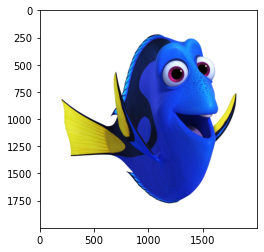

In [4]:
# Output RGB Image
fig = plt.figure()
plt.imshow(rgb_img)
plt.show()
# Source: Walt Disney Studios Motion Pictures

In [5]:
# Taking the mean of all channels to obtain monochrome image
# Weighted Method: Grayscale  = 0.299R + 0.587G + 0.114B
# Average Method: Grayscale = (R + G + B ) / 3.
arr_img = np.uint8(rgb_img[:,:,0]/3 + rgb_img[:,:,1]/3 + rgb_img[:,:,2]/3)
arr_img_weighted = np.uint8(rgb_img[:,:,0]*0.299 + rgb_img[:,:,1]*0.587 + rgb_img[:,:,2]*0.114)

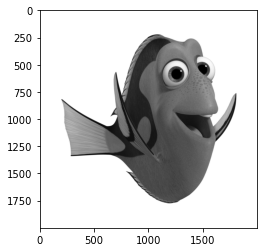

In [6]:
# Output Grayscale Image from Average Method
plt.imshow(arr_img, cmap='gray', vmin=0, vmax=255)
plt.show()

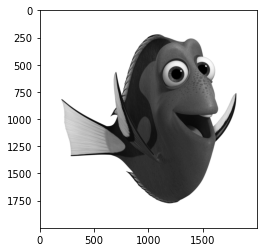

In [7]:
# Output Grayscale Image from Weighted Method
plt.imshow(arr_img_weighted, cmap='gray', vmin=0, vmax=255)
plt.show()

In [8]:
# We have proceeded to use the average method as it is more conventional

# Find length and breadth of image
[length,breadth] = arr_img.shape
length = int(length)
breadth = int(breadth)

print("Length of given image: ", length, "\nBreadth of given image: ", breadth)

# Define the ratio by which to downscale the image
# Downscaling the array makes it computationally less expensive to work with
n = 25

# Define an array to store downscaled array
arr_image = np.uint8(np.zeros((int(length/n), int(breadth/n))))

arr_tmp = np.zeros(n*n)

# Loop to find mean (could change it to the median) value of nxn moving window and assign it to downscaled array
for i in range(int(length/n)):
    for j in range(int(breadth/n)):
        arr_tmp[:] = 0
        for k in range(n):
            for l in range(n):
                arr_tmp[n*k+l] = arr_img[n*i + k,n*j + l]
        arr_image[i,j] = np.mean(arr_tmp)
        
[length_downscaled, breadth_downscaled] = arr_image.shape
length_downscaled = int(length_downscaled)
breadth_downscaled = int(breadth_downscaled)
print("Length of downscaled image: ", length_downscaled, "\nBreadth of downscaled image: ", breadth_downscaled)

Length of given image:  2000 
Breadth of given image:  2000
Length of downscaled image:  80 
Breadth of downscaled image:  80


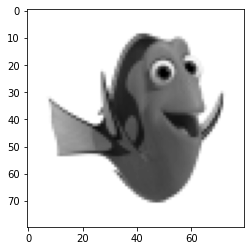

In [9]:
# Output Downscaled Grayscale Image
plt.imshow(arr_image, cmap='gray', vmin=0, vmax=255)
plt.show()

In [10]:
# Define Pythagoras Theorem
def Pythagoras(a,b):
    return np.sqrt(a**2 + b**2)

In [11]:
import time

# Declaring required constants
#s = 0            # Height of object point from centre of object
D = 8.67         # Perpendicular distance of object plane from image plane (in m)
R = 0            # Distance from centre of detector array to object
#theta = 0        # Angle subtended by R with respect to D
lbda = 700e-9    # Average wavelength of light, lambda
d = 0            # Space between the detectors

base_intensity = 1        # We know that I directly proportional to A**2, but not the constant of proportionality. base_intensity acts as that
pixel_width = 0.7e-6      # 0.7um
detector_spacing = 48e-3  # 48mm

# Declaring image plane array
# Number of detectors
num_detectors = 20        # The paper uses a 26x26 array but do note that a simulation of the classical regime isn't discussed in the paper.
                          # In the current block of code, we are trying to simulate the results of a classical optical sensor affected by 
                          # the diffraction limit of visible light
arr_plane = np.zeros((num_detectors,num_detectors))

# This is not strictly necessary but has been added here to depict the computational load of the step
start_time = time.time()

for i in range(num_detectors):
    for j in range(num_detectors):
        for k in range(length_downscaled):
            for l in range(breadth_downscaled):
                # Take a moment to appreciate the 2.56 million iterations that happen in under a minute and how computers have evolved over the years
                d = Pythagoras(((k-40+0.5)*pixel_width - (i-10+0.5)*detector_spacing), ((l-40+0.5)*pixel_width - (j-10+0.5)*detector_spacing))
                R = Pythagoras(d, D)
                arr_plane[i,j] += arr_image[k,l] * base_intensity/(R**2)
                
print("--- %s seconds ---" % (time.time() - start_time))

--- 77.77309012413025 seconds ---


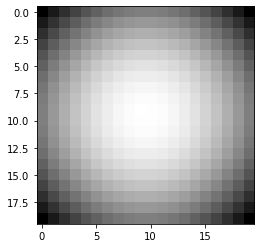

In [12]:
# Defining the digital number by appropriately scaling (normalising) the photon count as seen by a classical detector
DN = np.uint8((arr_plane-np.min(arr_plane))*255/(np.max(arr_plane)-np.min(arr_plane)))
plt.imshow(DN, cmap='gray', vmin=0, vmax=255)
plt.show()

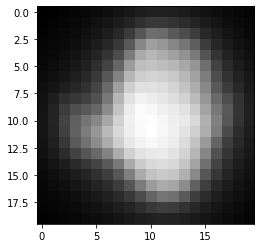

In [13]:
# The classical detector thus fails when the points on the object are very closely packed. It doesn't take into account the interference effects
# and blindly adds the intensities of the values as received. This results in blurred image as it crosses the diffraction limit

# Instead, if we assume a more real-life depiction with farther spaced object points
pixel_width = 2.5
detector_spacing = 10

arr_classical = np.zeros((num_detectors,num_detectors))
# Using the negative of the given image
arr_image = 255 - arr_image

for i in range(num_detectors):
    for j in range(num_detectors):
        for k in range(length_downscaled):
            for l in range(breadth_downscaled):
                d = Pythagoras(((k-40+0.5)*pixel_width - (i-10+0.5)*detector_spacing), ((l-40+0.5)*pixel_width - (j-10+0.5)*detector_spacing))
                R = Pythagoras(d, D)
                arr_classical[i,j] += arr_image[k,l] * base_intensity/(R**2)

DN2 = np.uint8((arr_classical-np.min(arr_classical))*255/(np.max(arr_classical)-np.min(arr_classical)))
plt.imshow(DN2, cmap='gray', vmin=0, vmax=255)
plt.show()

## Count, Click and Traditional Schemes
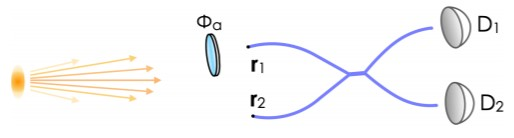

The incoming light fields at $r_1$ and $r_2$ are interfered at a beam splitter, the output of which is sent to detectors D1 and D2. In
the Count scheme the detectors are photon-number-resolving
and the phase shift $\phi_a$ is random; the Traditional scheme is
similar except the phase is fixed. In the Click scheme the
phase is random but the detectors are not number-resolving,
instead recording events if one or more photons are present.

# Experimental setup
The experimental apparatus of [[3]](https://arxiv.org/pdf/1811.02192.pdf), considers a 10kHz pulsed 820 nm laser, attenuated with a neutral density filter (ND1) which is then focused on a ground glass plate. The rotation of the ground glass plate converts the spatially coherent light into spatially incoherent light (thermal light). In the far-field, the light is collected into two optical fibres $r_1$ and $r_2$. The light entering $r_1$ is first passed through a rotating glass plate which results in the application of a relative phase shift $\phi_a$. The two optical fibres are connected to a 50:50 fibre beam splitter (FBS) where the light interferes and the output is then sent to photon-number-resolving detectors which are transition-edge sensors, TES1 and TES2, which measure incoming photons in the photon number basis. For stable interferometry, the mechanical fluctuations for the position of the optical fibres should be kept within $\lambda/5 = 40 mm$. In order to achieve this, the optical flat and the optical fibres are isolated within an acrylic box with a small hole towards the laser diode to let the light into the interferometer. The entire experiment is then further isolated in another box on a floating table. \\
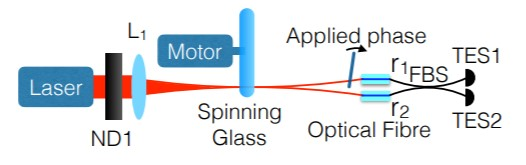




## Practical Implementation Requirements 
 
 - Need a two dimensional array of photon-number-resolving detectors and phase varying elements
   - A new methodology is cited is pair a (large) number of such detectors in an array
 - Construct the image by measuring the CDC values between all detector pairs (in the array) and calculating the source distribution through the Van Cittert-Zernike theorem. 

 - The Click scheme proves to be more economically viable as the Count scheme shows only modest improvements for big datasets
   - Only real advantage of Count scheme is in small datasets
 - The whole point was to avoid intensity-based interferometric methods which can't be used to estimate $|\gamma |$ and $\phi$ for incoherent light sources.
 - Authors expect improved imaging of stellar bodies and small biological entities

### Phase Characterisation

 - Orientation of *optical flat* in front of $r_1$ sets the phase shift $\phi_a$
 - $\phi$ vs **angle** of *optical flat* obtained by inputting a coherent state and measuring with PNR detector
   - First extremum (a minimum) of $[1,1]$ fringe is taken to correspond $\phi=0 \rightarrow [1,1]$ has good signal to noise ratio, *Hong-Ou-Mandel* effect, increased sensitivity of a two-photon NOON state
   - Extrema occur at steps of $\frac{\pi}{2}$
 - Function giving the relationship between the optical flat rotation position ($\alpha$) and applied phase of light entering $r_1$ ($\phi_a$) is plotted along with another plot $Probability$ vs $\alpha$. The former is square root-like and the latter is oscillatory (but not sinusoidal)
 - After performing phase characterisation, **a thermal state is inserted in the setup and the Count scheme is used to estimate the CDC of the source**
   - Assumption: Calibration between $\alpha$ and $\phi$ is unaffected by insertion of thermal state
   - The assumption is quite weak and if the deviation in calibration exceeds a particular threshold, the dataset is discarded

# Complex Degree of Coherence 

The CDC is defined as follows
$$\gamma_{12}(\tau) = \frac{\Gamma_{12}(\tau)}{\sqrt{I(x_1)I(x_2)}}$$
 where
$$\Gamma_{12}(\tau) = \Gamma(x_1, x_2, \tau)$$
is the the mutual coherence function.

The CDC can be extracted from the visibility of the fringes and written in the form [[3]](https://arxiv.org/pdf/1811.02192.pdf)
$$\gamma = |\gamma|e^{i\phi}$$ where $\phi$ is the phase of $\gamma$. \\
 According to the standard coherence theory, the intensity in the far field due to two points $1$ and $2$ in the source plane is given by [[3]](https://arxiv.org/pdf/1811.02192.pdf)
 $$I = I_1 + I_2 + 2\sqrt{I_1 I_2} |\gamma| cos \phi$$ 
The visibility of the fringes in the far field can then be calculated as[[3]](https://arxiv.org/pdf/1811.02192.pdf)$$\mathcal{V} = \frac{I_{max} - I_{min}}{I_{max} + I_{min}} = \frac{2\sqrt{I_1 I_2}}{I_1 + I_2} |\gamma|$$
where $I_{max}$ and $I_{min}$ are the maximum and minimum intensities in the far field. \\
Assuming a uniform intensity distribution $I_1 = I_2 \Rightarrow \mathcal{V} = |\gamma|$ \\


# Van Cittert-Zernike Theorem
Let $XY$ and $xy$ be respectively the cartesian coordinates of the source plane and the observation plane. Suppose the electric field due to some point from the source in the source plane is measured at two points, $P_{1}$ and $P_{2}$, in the observation plane. The position of a point in the source may be referred to by its direction cosines $(l, m)$. The van Cittert-Zernike theorem relates the CDC to the
source distribution via a two-dimensional Fourier transform
[[1]](https://link.springer.com/chapter/10.1007%2F978-3-319-44431-4_15) 
$$ \Gamma_{1,2}(u,v,\tau) = \iint_{Source} I(l,m)e^{-2\pi i(ul+vm + \tau)}dldm$$

where $I(l,m)$ is the intensity of the source. \\
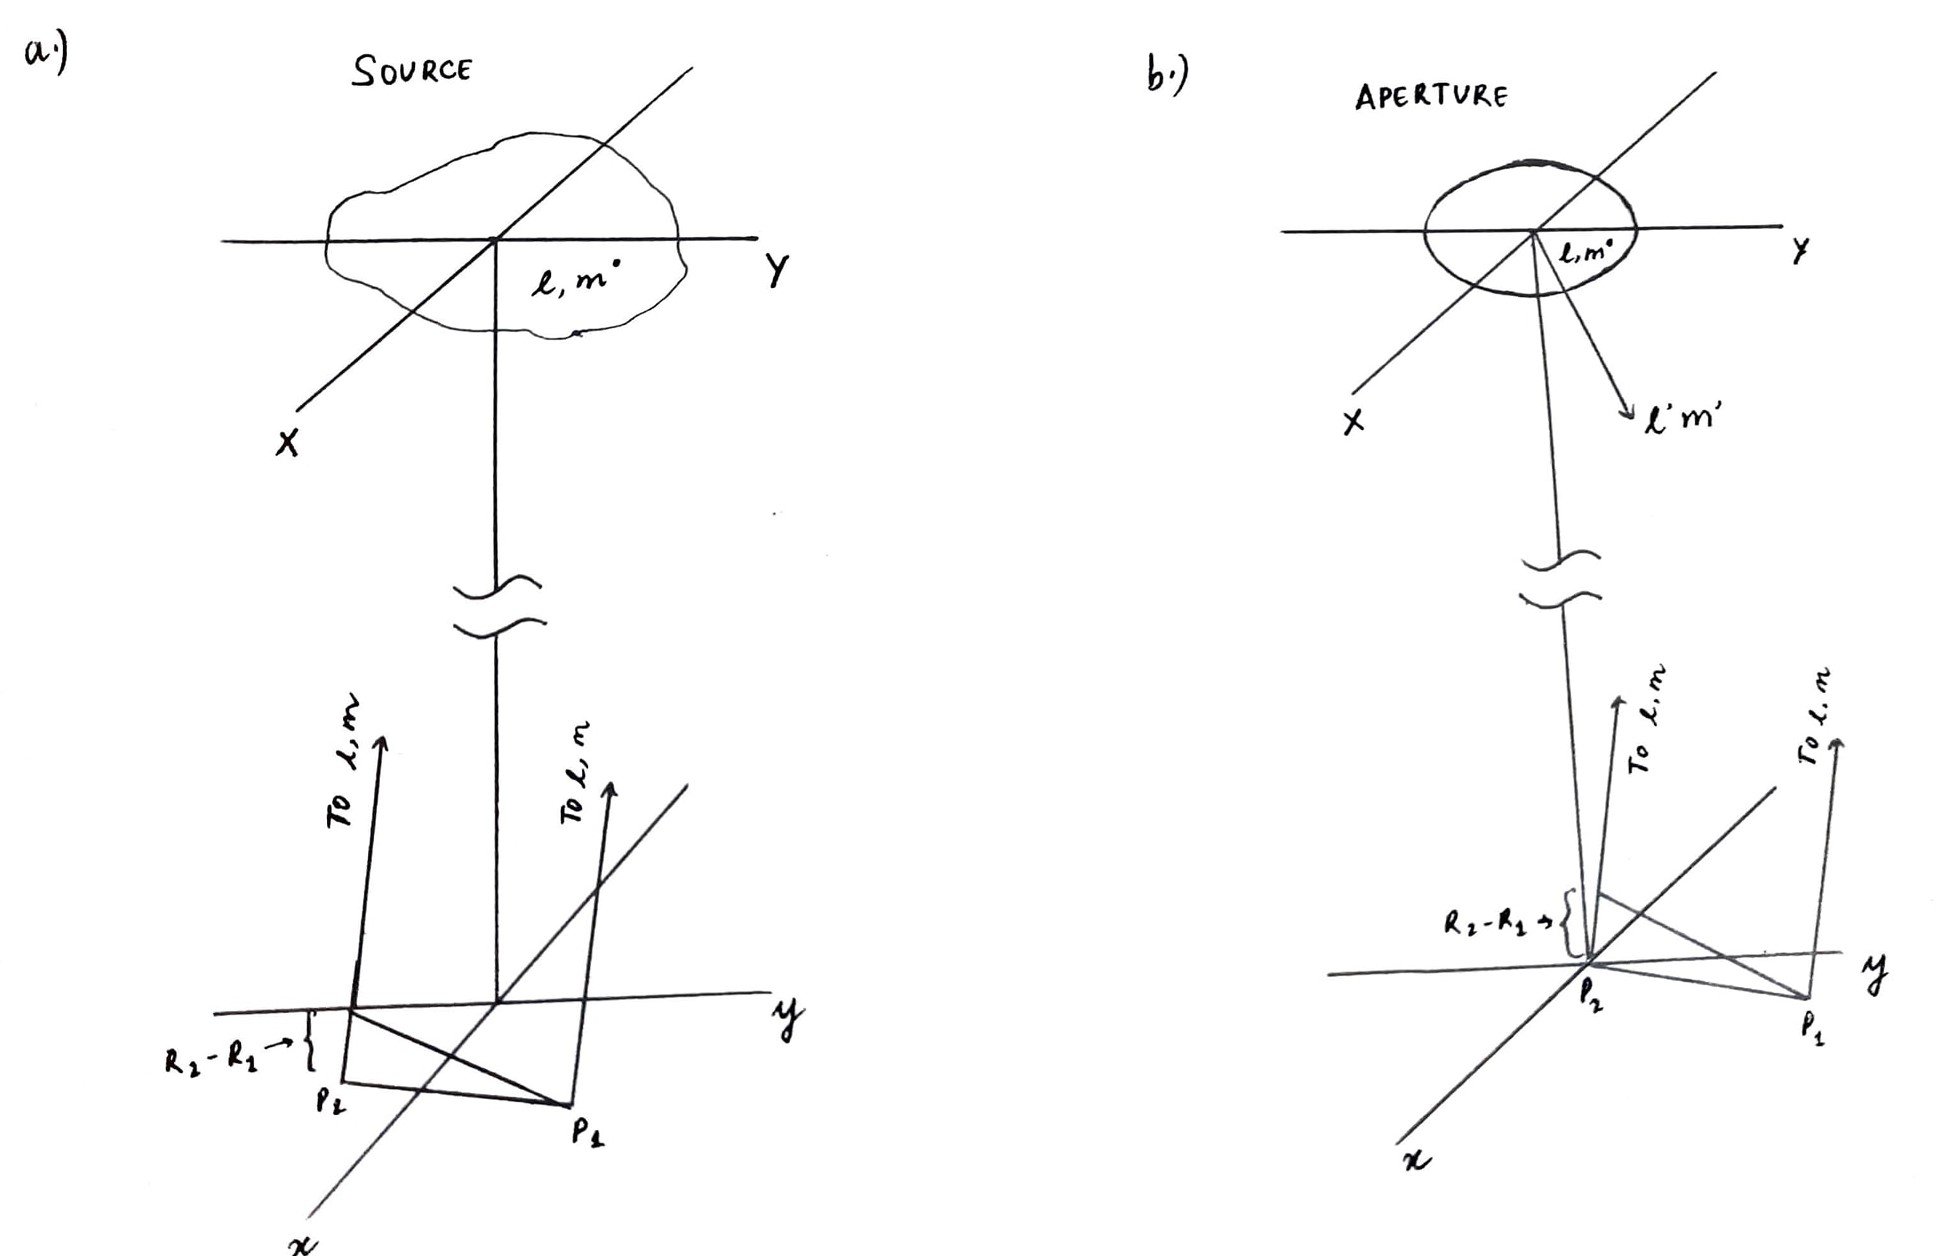

# Estimation of CDC 
The reference paper uses the experimental setup to calculate the $|\gamma|$ and $\phi$. The phase $\phi$ the CDC is equal to the applied phase $\phi_a$ at the point where the fringes are all at extremal values. To extract the values of $|\gamma|$ and $\phi$ from a measured interference fringe we use the maximum likelihood estimator (MLE).The MLE optimises $|\gamma|$ and $\phi$ to fit the experimental data to the probability distribution [[3]](https://arxiv.org/pdf/1811.02192.pdf)
$$Pr(x,y) = \sum_{n_1 = 0}^{x+y} \frac{p_{in}(n_1, x+y-n_1)}{n_1!(x+y-n_1)!} \frac{x!y!}{4^{x+y}} |P|^2$$
 where $$P = \sum^x_{j=0} (-1)^j \binom{n_1}{j} \binom{x+y-n_1}{x-j} (1 - e^{-i\phi})^{x+n_1-2j} (1 + e^{-i\phi})^{x-n_1+2j}$$
 and $$p_{in} (n_1,n_2) = \frac{z_1^{n_1}}{(1+z_1)^{n_1+1}} \frac{z_2^{n_2}}{(1+z_2)^{n_2+1}}$$
 and $$z_1 = \bar{n_1}(1-|\gamma|),\ z_2 = \bar{n_2}(1+|\gamma|)$$
 and $x$ and $y$ are the number of photons in detectors $D_1$ and $D_2$ respectively. \\
The paper [[3]](https://arxiv.org/pdf/1811.02192.pdf) compares the values of CDC obtained by the Count, Click and Traditional schemes averaged over
dataset sizes from 100 to 10000 points:


*   For $|\gamma|$, the Count
scheme is respectively 7.3 and 1.1 times more precise than
the the Traditional and Click schemes; 
*   For $\phi$, the Count
scheme is respectively 4.0 and 1.4 times more precise than
the the Traditional and Click schemes. \\


For the 10,000 point dataset, the Count
scheme is over an order-of-magnitude more precise for $|\gamma|$,
and four times more precise for $\phi$, than the Traditional
scheme. The same holds for comparisons between
the Click and Traditional schemes since the Count and Click schemes are of approximately equivalent precision for larger dataset sizes. 
These results demonstrate that the Count and Click schemes are
significantly better than the Traditional scheme. 






In [14]:
# Compute Factorial
'''
Input: n
'''
def comp_factorial(n):
  fact = 1
  for i in range(1,n):
    fact *= i
  return fact

# Compute Number of Combinations
'''
Input:
(n choose k)
1. n
2. k
'''
def comp_comb(n, k):
  return (comp_factorial(n) / (comp_factorial(n - k) * comp_factorial(k)))

# Compute z1 and z2
''' 
Input: 
1. n1, n2
2. gamma - visibility
'''
def comp_z1(n1, gamma):
  n1_bar = np.conjugate(n1)
  return (n1_bar*(1 - np.abs(gamma)))
def comp_z2(n2, gamma):
  n2_bar = np.conjugate(n2)
  return (n2_bar*(1 + np.abs(gamma)))

# Compute p_in
'''
Input:
1. n1, n2
2. gamma - visibility
'''
def comp_p_in(n1, n2, gamma):
  z1 = comp(n1, gamma)
  z2 = comp(n2, gamma)
  return ((z1**n1 * z2**n2) / ((1 + z1)**(n1 + 1) * (1 + z2)**(n2 + 1)))

# Compute P
'''
Input: Nil
'''
def comp_P(x, y, n1, phi):
  sum = 0
  for j in range(0, x):
    # Be careful with the iterator variable j and the j that represents square root of negative one
    sum += (-1)**j * comp_comb(n1, j) * comp_comb(x+y-n1, x-j) * (1 - np.exp(-1j*phi))**(x + n1 - 2*j) * (1 + np.exp(-1j*phi))**(x - n1 + 2*j)
  return sum

# Maximum Likelihood Estimator
'''
Input: x and y - the number of photons in detectors D1 and D2 respectively
Output: Probability Function Pr(x,y)
'''
def MLE(x, y, gamma, phi):
  sum = 0
  for n1 in range(0, x+y):
    n2 = x + y - n1
    sum += ((comp_p_in(n1, n2, gamma) * comp_factorial(x) * comp_factorial(y) * np.abs(comp_P(x, y, n1, phi))**2) / (comp_factorial(n1) * comp_factorial(n2) * 4**(x+y)))
  return sum

# Image Simulation and Reconstruction
In order to demonstrate the effect of noise in the imaging process, we used a picture of Dory in grey, and assumed a 80 × 80 detector array to reconstruct the image. We used the van Cittert-Zernike theorem to calculate the CDC for each detector pair. We used parameters given in the paper to project the object plane to the image plane and then added random Gaussian noise to the calculated CDC for each detector pair, the magnitude of which was chosen according to the experimental values of the uncertainty in the CDC given in the paper. A two-dimensional Fourier transform was then taken to reconstruct the intensity distribution in the source plane. \\
For the imaging simulation, we choose a wavelength of 700 nm, a separation between the pixels of 0.7 $\mu$m and the distance between the source and the detector plane as 8.67 m.


In [15]:
arr_img = arr_image

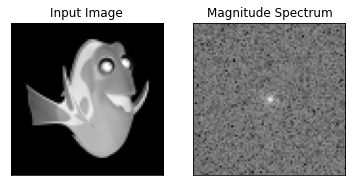

In [16]:
MutCoh = cv2.dft(np.float32(255-arr_img),flags = cv2.DFT_COMPLEX_OUTPUT)
MutCoh_Rearranged = np.fft.fftshift(MutCoh)
#print(type(dft_shift), dft_shift.shape)
#NormConst = 10*math.sqrt(np.mean(dft_shift**2))
NormConst = np.sum(np.sum(255-arr_img))
CDC = MutCoh_Rearranged/NormConst
Noisy_CDC = np.zeros((80,80,2))
#sigma1 = np.median(NormCDC[:,:,0])/5
sigma = 0.007
for i in range(80):
    for j in range(80):
        Noisy_CDC[i,j,0] = CDC[i,j,0] + np.random.normal(0, sigma)
        Noisy_CDC[i,j,1] = CDC[i,j,1] + np.random.normal(0, sigma)
        #print(np.median(arr_modified))
NoisyMutCoh = Noisy_CDC*NormConst
magnitude_spectrum = 20*np.log(cv2.magnitude(NoisyMutCoh[:,:,0],NoisyMutCoh[:,:,1]))

plt.subplot(121),plt.imshow(arr_img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()
#print(NormCDC)
#print(np.max(CDC))

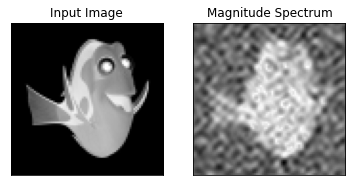

In [17]:
rows, cols = arr_img.shape
crow,ccol = int(rows/2) , int(cols/2)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-15:crow+15, ccol-15:ccol+15] = 1

# apply mask and inverse DFT
fshift = NoisyMutCoh*mask
#fshift = NoisyMutCoh
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(arr_img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(255-img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

# Quantum Cramér-Rao Bound
For two sources with overlapping radiations on the
image plane the precision of determining their location in the presence of photon shot noise quickly deteriorates when Rayleigh’s criterion is violated. The Quantum Cramér-Rao Bound, is given by [[2]](https://www.researchgate.net/publication/283471085_Quantum_Theory_of_Superresolution_for_Two_Incoherent_Optical_Point_Sources)
$$\Sigma_{\mu\mu} \geq (\mathcal{J}^{-1})_{\mu\mu} \geq (\mathcal{K}^{-1})_{\mu\mu}$$ where $\mathcal{J}$ is the classical Fisher information matrix and $\mathcal{K}$ is the quantum Fisher information matrix in terms of $\rho^{\otimes M}$ which denotes a tensor product of M density operators. 

Assuming a spatially invariant imaging system with $\psi_s = \psi(x-X_s)$, $s=1, 2 $; where $\psi$ is the point-spread function of the imaging system and $X_s$ is the unknown position of each source, $\mathcal{K}$ can be computed analytically. We diagonalise $\mathcal{K}$ by defining paameters 
$$\theta_1 = (X_1+X_2)/2$$ and 
$$\theta_2 = X_1-X_2$$ 
Therefore, the elements of the matrix becomes
$$\mathcal{K}_{11} = 4N(\Delta k^2-\gamma^2),\; \mathcal{K}_{22} = N\Delta k^2,\; \mathcal{K}_{12} = \mathcal{K}_{21}\sim 0$$
where 
$$\Delta k^2 = \int_{-\infty}^{\infty}dx \left(\frac{d\psi(x)}{dx}\right)^2$$ and 
$$\gamma = \int_{-\infty}^{\infty}dx \frac{d\psi(x)}{dx}\psi(x-\theta_2)$$
If we let our point spread function to be a gaussian distribution such that 
$\psi(x) = \frac{1}{(2\pi\sigma)^{1/4}}e^{-\frac{x}{4\sigma^2}}$ where $\sigma$ is the
width of the point-spread function, then
$$\mathcal{K}_{22} = \frac{N}{4\sigma^2}$$


In [18]:
#Define a gaussian with a specified width and mean = 0 
def gauss(x,std):
    return ((std**2)*2*np.pi)**(-0.25)*np.exp(-x**2/(4*std**2))

def K_matrix(N_photons, x, std, X_1, X_2):
    '''
    Returns the quantum fischer information matrix
    
        Parameters:
        N_photons(float): the average photon number collected over M intervals
        x(array-like): position coordinate 
        std(float): standard deviation of the point spread function
        X_1 (float): Position of the first source
        X_2 (float): Position of the second source
        
        Returns:
        K(matrix): quantum fischer information matrix 
    '''
    psi = gauss(x, std) 
    theta_1 = (X_1 + X_2)/2 #centroid of the sources 
    theta_2 = X_2 - X_1 #separation of the sources

  #computing delta k  
    delta_k = 1/(2*std) 

  #computing gamma 
    psi_2 = gauss(x-theta_2, std) #psi(x-theta_2)
    integrand_gamma = -psi*x/(2*std**2)*psi_2
    gamma = quad(integrand_gamma, -np.inf, np.inf)[0]
    

  #Computing elements of the quantum fischer information matrix 
    K_11 = N_photons*delta_k**2
    K_22 = 4*N_photons*(delta_k**2-gamma**2)
    K = [[K_11, 0], [0, K_22]]
    return K



In [ ]:
x = np.linspace(-10,10,100)
K = K_matrix(100,x,0.1,-0.15,0.15)
print(K)

## Individual Contributions


1.   Moysha Gera (190260031): Studied and analysed components of the experimental setup and compiled the introduction and experimental setup for the notebook.  
2.   Malavika (190260014): Studied about the Quantum Cramer-Rao Bound and analysed the Quantum Fisher Information Matrix and wrote the corresponding code, also wrote the theory in this notebook.
3.   Manan Seth (190260028): Studied the Van Cittert-Zernike Theorem and the Complex degree of Coherence, wrote the quantum simulation and image reconstruction code 
4.   Aravind Bharathi (190260009): Wrote the code for the Classical Simulation and Maximum Likelihood Estimator, studied the Fisher Information Matrix and looked for information theoretic approaches to solving the problem, and worked on the Quantum Simulation and Image Reconstruction algorithm